https://www.kaggle.com/code/shravankumar147/cityscapes-model-training

In [1]:
import os
import zipfile

#Base de datos
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
100% 201M/202M [00:11<00:00, 22.7MB/s]
100% 202M/202M [00:11<00:00, 18.9MB/s]


In [3]:
local_zip = '/content/cityscapes-image-pairs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#base_dir = "/kaggle/input/cityscapes-image-pairs/cityscapes_data"

#train_dir = f"{base_dir}/train"
#val_dir = f"{base_dir}/val"

training_images  = glob("/content/cityscapes_data/train/*")
validation_images  = glob("/content/cityscapes_data/val/*")

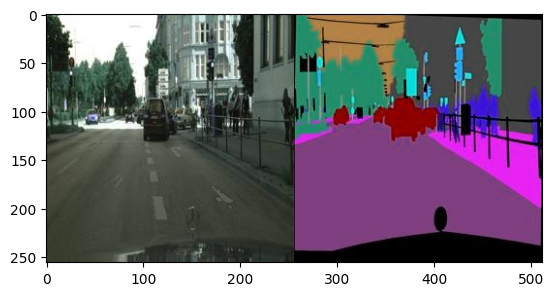

In [5]:
input_image_path = training_images[0]
train_image = cv2.imread(input_image_path)
plt.imshow(train_image)

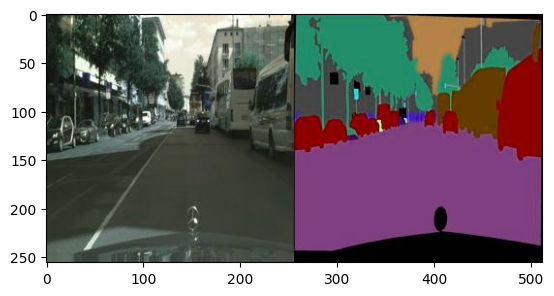

In [6]:
input_image_path = validation_images[0]
val_image = cv2.imread(input_image_path)
plt.imshow(val_image)

In [7]:
print(len(training_images))
print(len(validation_images))

2975
500


In [8]:
train_image.shape

(256, 512, 3)

In [9]:
train_image[:,:256,:].shape, train_image[:,256:,:].shape

((256, 256, 3), (256, 256, 3))

In [10]:
image, mask = train_image[:,:256,:], train_image[:,256:,:]

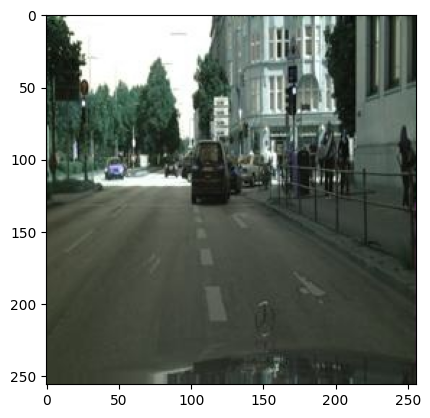

In [11]:
plt.imshow(image)

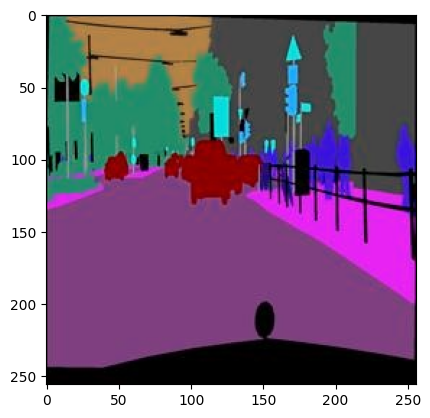

In [12]:
plt.imshow(mask)

In [13]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor
# import torch.multiprocessing as mp

In [14]:
# mp.set_start_method('spawn', force=True)

class CityscapesDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.image_paths = glob(os.path.join(self.data_dir, split, '*.jpg'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        train_image = cv2.imread(img_path)

        # Separate the concatenated image into the main image and its corresponding label (mask)
        image = train_image[:, :256, :]
        mask = train_image[:, 256:, :]

        # Apply transformations separately to image and mask
        if self.transform:
            image = self.transform['image'](image)
            mask = self.transform['mask'](mask)

        return image, mask, img_path

In [15]:
base_dir = '/content/cityscapes_data'

# Define separate transformation pipelines for image and mask
image_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])
mask_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])

data_transform = {'image': image_transform, 'mask': mask_transform}

In [16]:
train_dataset = CityscapesDataset(base_dir, split='train', transform=data_transform)
val_dataset = CityscapesDataset(base_dir, split='val', transform=data_transform)

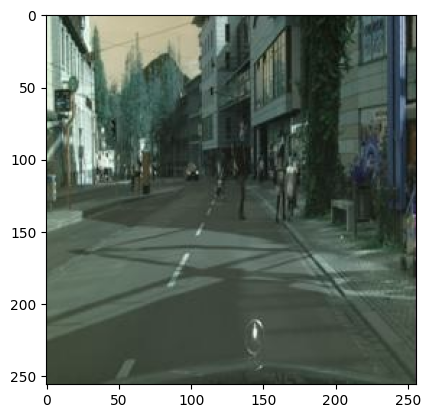

In [17]:
# Example of accessing data
image, mask, image_path = train_dataset[3]
plt.imshow((image.permute(1, 2, 0).numpy()*255).astype(np.uint8))

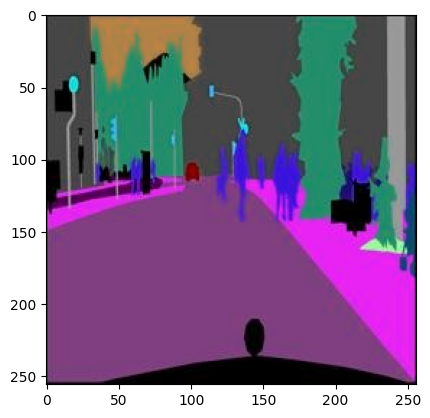

In [18]:
plt.imshow((mask.permute(1, 2, 0).numpy()*255).astype(np.uint8), cmap='gray')
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder part
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # Decoder part
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))

        # Bottleneck part
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        # Final output layer
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skips = []
        for down in self.encoder:
            x = down(x)
            skips.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skips = skips[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip = skips[idx // 2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            concat_skip = torch.cat((skip, x), dim=1)
            x = self.decoder[idx + 1](concat_skip)

        return self.final(x)

In [21]:
# Parameters
batch_size = 8
num_workers = 1

# DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
#Quick test over small subset of data

from torch.utils.data import Subset
import numpy as np

# Load full dataset
train_dataset_full = train_dataset
val_dataset_full = val_dataset

# Define subset size
subset_size = 100  # Number of samples for quick test

# Generate random indices for the subset
train_indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)
val_indices = np.random.choice(len(val_dataset_full), subset_size, replace=False)

# Create subset
train_subset = Subset(train_dataset_full, train_indices)
val_subset = Subset(val_dataset_full, val_indices)

# Create DataLoader for the subset
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(train_dataset_full), len(val_dataset_full)

train_loader = train_loader_subset
val_loader = val_loader_subset

In [23]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for images, masks, _ in dataloaders[phase]:
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

    return model

In [29]:
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [34]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
}


num_epochs = 50
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.0420
val Loss: 0.0459
Epoch 1/49
----------
train Loss: 0.0318
val Loss: 0.0305
Epoch 2/49
----------
train Loss: 0.0281
val Loss: 0.0285
Epoch 3/49
----------
train Loss: 0.0268
val Loss: 0.0281
Epoch 4/49
----------
train Loss: 0.0256
val Loss: 0.0253
Epoch 5/49
----------
train Loss: 0.0241
val Loss: 0.0254
Epoch 6/49
----------
train Loss: 0.0236
val Loss: 0.0253
Epoch 7/49
----------
train Loss: 0.0243
val Loss: 0.0263
Epoch 8/49
----------
train Loss: 0.0220
val Loss: 0.0236
Epoch 9/49
----------
train Loss: 0.0207
val Loss: 0.0223
Epoch 10/49
----------
train Loss: 0.0208
val Loss: 0.0229
Epoch 11/49
----------
train Loss: 0.0203
val Loss: 0.0231
Epoch 12/49
----------
train Loss: 0.0193
val Loss: 0.0229
Epoch 13/49
----------
train Loss: 0.0188
val Loss: 0.0209
Epoch 14/49
----------
train Loss: 0.0188
val Loss: 0.0224
Epoch 15/49
----------
train Loss: 0.0177
val Loss: 0.0209
Epoch 16/49
----------
train Loss: 0.0173
val Loss: 0.0209
Epoch 1

In [35]:
torch.save(model.state_dict(), '/content/drive/MyDrive/TEC/Research/Semantic Segmentation/unet_cityscapes_50Epochs.pth')

In [36]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/unet_cityscapes_50Epochs.pth'))
model.eval()

# Example: Predict on a validation sample
images, masks, _ = next(iter(val_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)

<ipython-input-36-662b45aacc30>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/

In [37]:
import torch
import numpy as np

def calculate_iou(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask).sum()
    union = np.logical_or(predicted_mask, target_mask).sum()
    iou = intersection / (union + 1e-10)  # Adding a small epsilon to avoid division by zero
    return iou

def calculate_pixel_accuracy(predicted_mask, target_mask):
    correct_pixels = (predicted_mask == target_mask).sum()
    total_pixels = target_mask.size
    accuracy = correct_pixels / total_pixels
    return accuracy

# Assuming outputs and masks are tensors of shape [batch_size, num_classes, height, width]
# Convert outputs and masks to numpy arrays
outputs_np = outputs.cpu().detach().numpy()  # Detach from computational graph and move to CPU
masks_np = masks.cpu().detach().numpy()

iou_scores = []
pixel_accuracies = []

for i in range(len(outputs_np)):
    predicted_mask = np.argmax(outputs_np[i], axis=0)  # Assuming outputs are logits, take argmax
    target_mask = masks_np[i, 0]  # Assuming masks are binary or integer labels (0 for background)

    # Calculate IoU and pixel accuracy for each sample
    iou = calculate_iou(predicted_mask, target_mask)
    pixel_acc = calculate_pixel_accuracy(predicted_mask, target_mask)

    iou_scores.append(iou)
    pixel_accuracies.append(pixel_acc)

# Calculate mean IoU and mean pixel accuracy over the entire validation set
mean_iou = np.mean(iou_scores)
mean_pixel_acc = np.mean(pixel_accuracies)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_acc:.4f}")

Mean IoU: 0.5921
Mean Pixel Accuracy: 0.0116


In [38]:
# Save a sample output for visual verification
save_image(images, 'sample_input.png')
save_image(outputs, 'sample_output.png')

In [39]:
images.shape

torch.Size([8, 3, 256, 256])

In [40]:
outputs.shape

torch.Size([8, 3, 256, 256])

In [41]:
import matplotlib.pyplot as plt

# Load the saved input and output images
input_img = plt.imread('sample_input.png')
output_img = plt.imread('sample_output.png')

# Create a figure with subplots
fig, axs = plt.subplots(2,1, figsize=(12*2, 6*2))

# Display the input image in the first subplot
axs[0].imshow(input_img)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

# Display the output image in the second subplot
axs[1].imshow(output_img)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Output Image')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Cargar el modelo entrenado y seguir haciendo pruebas
#'/content/drive/MyDrive/TEC/Research/Semantic Segmentation/unet_cityscapes.pth'

# **Visualización de Feature maps**

In [42]:
# Example: Predict on a validation sample
images, masks, _ = next(iter(val_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)

In [46]:
np.shape(images[0])

torch.Size([3, 256, 256])

In [50]:
save_image(images[0], 'Entrada.png')
Entrada = plt.imread('Entrada.png')

Text(0.5, 1.0, 'Input Image')

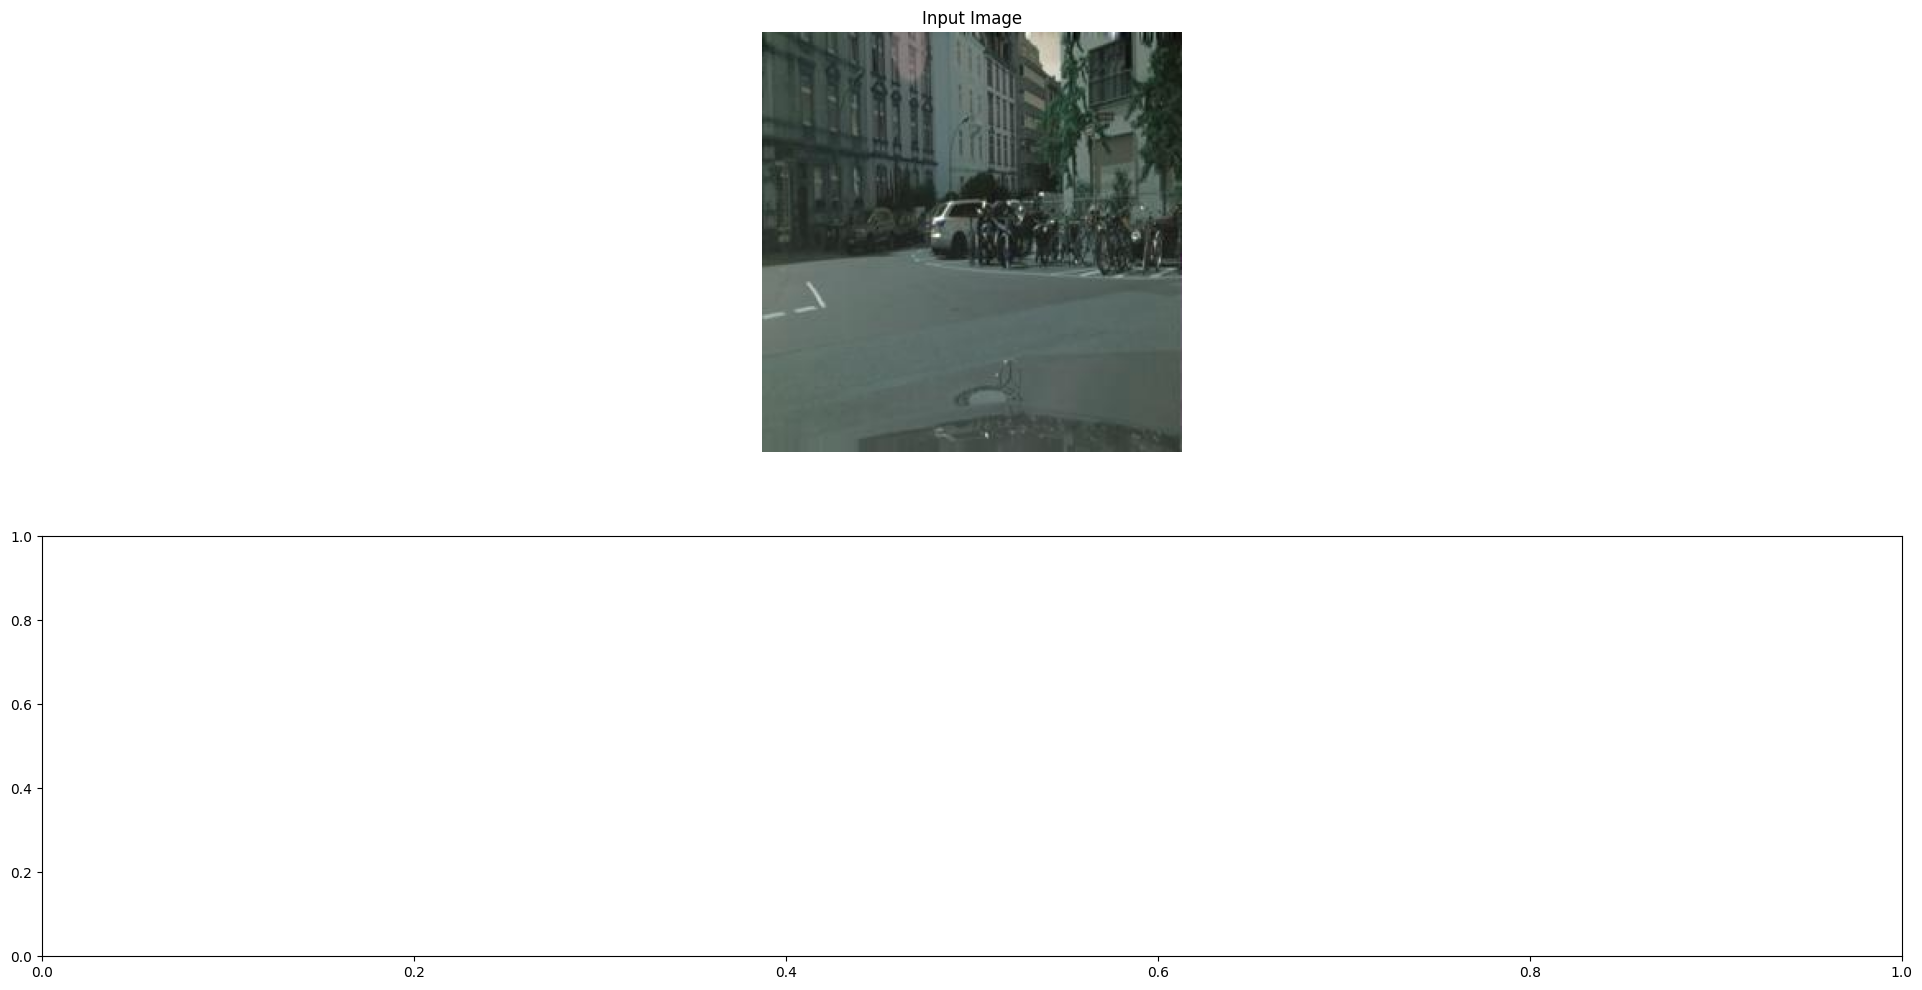

In [51]:
fig, axs = plt.subplots(2,1, figsize=(12*2, 6*2))

axs[0].imshow(Entrada)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

In [53]:
print(model)

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNor

In [ ]:
outputs = []
names = []

for layer in